# Modelling the World in Data

In this notebook we will model world development, inspired by the presentations of [Hans Rosling on 200 years that changed the world](https://https://www.gapminder.org/videos/200-years-that-changed-the-world/).

We will go through the steps of downloading data from an Application Programming Interface (API), plotting it, fitting a linear regression model (with non-linear terms) and then using a model to make future predictions. 

## 1 Downloading the data

First we install the World Bank API in order to download the data.

In [ ]:
#Install package if not available.
!pip install world_bank_data

#Import libraries
#Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
#Dataframes (panda) and math opperations (numpy)
import pandas as pd
import numpy as np
#World bank data interface
import world_bank_data as wb
#Import machine learning tools (for linear regression)
import sklearn.linear_model as skl_lm
import itertools
import math

# Default plotting options.
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

Now we download the data set, indexed with the country code.

The data is downloaded from here https://databank.worldbank.org/home

In [ ]:
gdp_percapita = wb.get_series('NY.GNP.PCAP.CD', id_or_value='id', simplify_index=True)
gdp_percapita
childmortality = wb.get_series('SH.DYN.MORT', id_or_value='id', simplify_index=True)
childmortality

Country  Year
AFE      1960     NaN
         1961     NaN
         1962     NaN
         1963     NaN
         1964     NaN
                 ... 
ZWE      2017    57.0
         2018    54.8
         2019    54.2
         2020    53.9
         2021     NaN
Name: SH.DYN.MORT, Length: 16492, dtype: float64

Now we reorganise the data so it is in a dataframe (like an Excel spreadsheet) with columns Year, Country, Child Mortality (per 10,000 births) ($C(k)$), log Gross Domestic Product per person ($G(k)$) and change in these two variables --- $C(k+1)-C(k)$ and $G(k+1)-G(k)$ --- over time $k$. 

(This can take one minute or so to run)

In [ ]:
cm=childmortality.to_frame()
gdp=gdp_percapita.to_frame()

df = pd.DataFrame(columns=('Year', 'Country','Child Mortality','GDP','Diff CM','Diff GDP'))
countries = cm.index
this_country=''
this_cm=0
this_gdp=0
j=0

for i,c in enumerate(countries):
    

    prev_cm=this_cm
    prev_gdp=this_gdp
    prev_country=this_country
        
    #Update for this year.
    this_year=c[1]
    this_cm=cm.iloc[i]['SH.DYN.MORT']
    this_gdp=np.log(gdp.iloc[i]['NY.GNP.PCAP.CD'])
    this_country=c[0]
    
    if (prev_country==this_country):
        #Update differences and put in matrix
        diff_cm=this_cm-prev_cm
        diff_gdp=this_gdp-prev_gdp
        if not(np.isnan(diff_cm) or np.isnan(diff_gdp)):
            df.loc[j] = [this_year,this_country,this_cm,this_gdp,diff_cm,diff_gdp]
            j=j+1

df.head()

,Year,Country,Child Mortality,GDP,Diff CM,Diff GDP
0,1991,AFE,164.128976,6.519685,-1.672551,0.007455
1,1992,AFE,162.511815,6.499524,-1.617161,-0.020161
2,1993,AFE,161.204106,6.519203,-1.307709,0.019680
3,1994,AFE,161.556769,6.530270,0.352663,0.011067
4,1995,AFE,156.602259,6.597989,-4.954509,0.067719


## 2 Single variable model 

### 2.1 Plotting the data
We now plot how child mortality has changed in four countries (Sweden, USA, Uganda and China).

In order look at other countries you can find their codes by looking here https://data.worldbank.org/country and clicking on the country and then clicking on (i) to see country code.

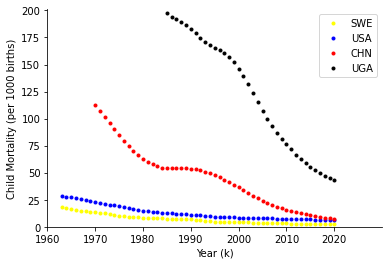

In [ ]:
countries=['SWE','USA','CHN','UGA']
country_colour_dict= {
  "USA": "blue",
  "CHN": "red",
  "SWE": "yellow",
  "UGA": "black",
  "AFG": "green"
}

fig,ax=plt.subplots(num=1)
for country in countries:
    df_country=df.loc[df['Country'] == country]

    years=np.array(df_country['Year']).astype('int32')
    ax.plot(years,df_country['Child Mortality'],linestyle='none', color =country_colour_dict[country], markersize=3, marker='o',label=country)
ax.legend()
ax.set_xticks(np.arange(1960,2030,step=10))
ax.set_yticks(np.arange(0,225,step=25))
ax.set_ylabel('Child Mortality (per 1000 births)')
ax.set_xlabel('Year (k)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(1960,2030)
ax.set_ylim(0,201) 

plt.show()

### 2.2 Fitting a model to child mortality

Now we fit a linear regression model
$$
y(k) = C(k+1) - C(k) = a + b_0 C(k) + b_1 C(k)^2 + b_2 C(k)^3 + \epsilon, \qquad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$
to describe the change in child mortality from one year to the next. 

To do this we use scikitlearn library in Python.

In [ ]:
#Create the variables
df['C2'] = df['Child Mortality']**2
df['C3'] = df['Child Mortality']**3
X_train = df[['Child Mortality','C2','C3']]
y_train = df['Diff CM']
model = skl_lm.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
# Print the coefficients
print('The coefficients are:', model.coef_)
print(f'The offset is: {model.intercept_:.3f}')
b = model.coef_
a=model.intercept_

The coefficients are: [-5.06386729e-02  1.48003409e-04 -4.32047300e-08]
The offset is: 0.093


We can now plot the fitted model on the same plot as the data.

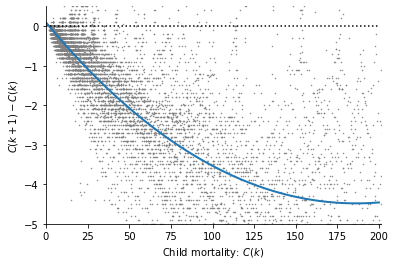

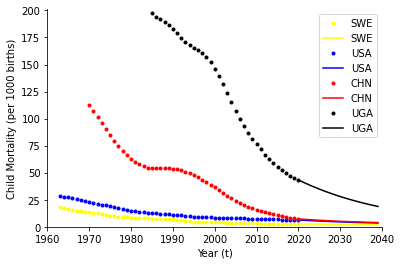

In [ ]:
#Implement the model
C = np.arange(0,200,0.1)
dC = a + b[0] * C + b[1]*C**2 + b[2]*C**3

#Make the plot
fig,ax=plt.subplots(num=1)
ax.plot(df['Child Mortality'],df['Diff CM'],linestyle='none', markersize=1,color='grey',marker='.')
ax.plot(C,dC,linewidth=2)
ax.plot([0 ,200],[0, 0],linestyle=':',color='black')
ax.set_yticks(np.arange(-5,0.5,step=1))
ax.set_xticks(np.arange(0,225,step=25))
ax.set_ylabel('$C(k+1)-C(k)$')
ax.set_xlabel('Child mortality: $C(k)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,201) 
ax.set_ylim(-5,0.5) 
plt.show()

#Predict future evoltion of child mortality
fig,ax=plt.subplots(num=1)
for country in countries:
    df_country=df.loc[df['Country'] == country]

    years=np.array(df_country['Year']).astype('int32')
    ax.plot(years,df_country['Child Mortality'],linestyle='none', color =country_colour_dict[country], markersize=3, marker='o',label=country)
  
    numyears=20
    future_CM=np.zeros(numyears)
    future_CM[0]=df_country['Child Mortality'][-1:]
    
    
    for t in range(numyears-1):
        future_CM[t+1]=future_CM[t]+ a + b[0] * future_CM[t] + b[1]*future_CM[t]**2 + b[2]*future_CM[t]**3
    
    ax.plot(int(df_country['Year'][-1:])+np.arange(numyears),future_CM, color =country_colour_dict[country],linestyle='-',label=country)
ax.legend()
ax.set_xticks(np.arange(1960,2045,step=10))
ax.set_yticks(np.arange(0,225,step=25))
ax.set_ylabel('Child Mortality (per 1000 births)')
ax.set_xlabel('Year (t)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(1960,2040)
ax.set_ylim(0,201)   
plt.show()


### 2.3 Fitting a model to log GDP

**Task:** Now it is your turn! Fit a linear regression model
$$
y(k) = G(k+1) - G(k) = a + b_0 G(k) + b_1 G(k)^2 + \epsilon, \qquad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$
to describe the change in GDP from one year to the next. 

The code below is incomplete. Complete it by filling in the ???? to first make the plot.

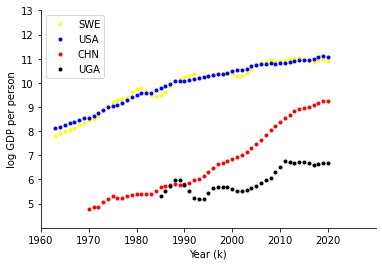

In [ ]:
fig,ax=plt.subplots(num=1)
for country in countries:
    df_country=df.loc[df['Country'] == country]

    years=np.array(df_country['Year']).astype('int32')
    ax.plot(years,df_country['GDP'],linestyle='none', color =country_colour_dict[country], markersize=3, marker='o',label=country)
ax.legend()
ax.set_xticks(np.arange(1960,2030,step=10))
ax.set_yticks(np.arange(5,14,step=1))
ax.set_ylabel('log GDP per person')
ax.set_xlabel('Year (k)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(1960,2030)
ax.set_ylim(4,13) 

plt.show()

And to fit the model asked for by filling in the missing info...

In [ ]:
#Create the variables
df['G2'] = df['GDP']**2
#Set up the model
X_train = df[['GDP','G2']]
y_train = df['Diff GDP']
#Fit the model
model = skl_lm.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
# Print the coefficients
print('The coefficients are:', model.coef_)
print(f'The offset is: {model.intercept_:.3f}')
b = model.coef_
a=model.intercept_

The coefficients are: [ 0.05143308 -0.003319  ]
The offset is: -0.142


And here you should fill in everything needed to make the plots.


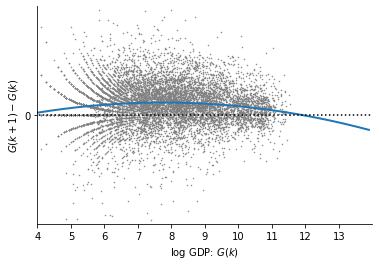

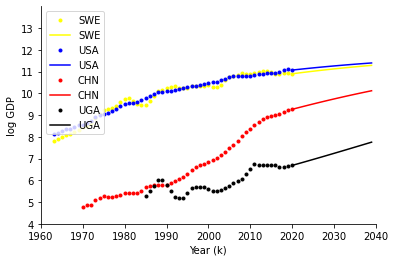

In [ ]:
G = np.arange(0,14,0.1)
dG = a + b[0] * G + b[1]*G**2 

#Make the plot
fig,ax=plt.subplots(num=1)
ax.plot(df['GDP'],df['Diff GDP'],linestyle='none', markersize=1,color='grey',marker='.')
ax.plot(G,dG,linewidth=2)
ax.plot([0 ,200],[0, 0],linestyle=':',color='black')
ax.set_yticks(np.arange(-5,0.5,step=1))
ax.set_xticks(np.arange(4,14,step=1))
ax.set_ylabel('$G(k+1)-G(k)$')
ax.set_xlabel('log GDP: $G(k)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(4,14) 
ax.set_ylim(-0.5,0.5) 
plt.show()

#Predict future evoltion of child mortality
fig,ax=plt.subplots(num=1)
for country in countries:
    df_country=df.loc[df['Country'] == country]

    years=np.array(df_country['Year']).astype('int32')
    ax.plot(years,df_country['GDP'],linestyle='none', color =country_colour_dict[country], markersize=3, marker='o',label=country)
  
    numyears=20
    future_GDP=np.zeros(numyears)
    future_GDP[0]=df_country['GDP'][-1:]
    
    
    for t in range(numyears-1):
        future_GDP[t+1]=future_GDP[t]+ a + b[0] * future_GDP[t] + b[1]*future_GDP[t]**2 

    ax.plot(int(df_country['Year'][-1:])+np.arange(numyears),future_GDP, color =country_colour_dict[country],linestyle='-',label=country)
ax.legend()
ax.set_xticks(np.arange(1960,2045,step=10))
ax.set_yticks(np.arange(4,14,step=1))
ax.set_ylabel('log GDP')
ax.set_xlabel('Year (k)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(1960,2040)
ax.set_ylim(4,14)   
plt.show()

## 3 Two variable model

### 3.1 Plotting the data

We now make a Gapminder style plot of the data.


(5.0, 11.5)

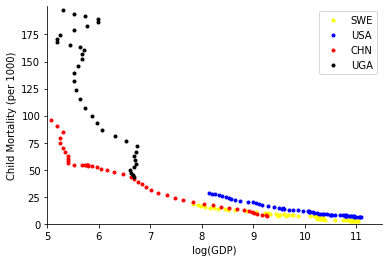

In [ ]:
# Plot phase portrait
fig,ax=plt.subplots(num=1)
for country in countries:
    df_country=df.loc[df['Country'] == country]
    ax.plot(df_country['GDP'], df_country['Child Mortality'],linestyle='none', markersize=3, color =country_colour_dict[country],  marker='o',label=country)
    
ax.legend()
ax.set_xticks(np.arange(5,12,step=1))
ax.set_yticks(np.arange(0,200,step=25))
ax.set_ylabel('Child Mortality (per 1000)')
ax.set_xlabel('log(GDP)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,201) 
ax.set_xlim(5,11.5) 


### 3.2 Fitting a model to data

Now we fit a linear regression model where child mortality and GDP can influence each other. We assume that
$$
y_C(k) = C(k+1) - C(k) = a_C + b_{C0} C(k) + b_{C1} C(k)^2 + b_{C2} C(k)^3 + b_{C3} G(k) + b_{C4} G(k)^2 + b_{C5} C(k) G(k) + \epsilon_C(k), \qquad \epsilon_C(k) \sim \mathcal{N}(0, \sigma_C^2)
$$
and
$$
y_G(k) = G(k+1) - G(k) = a_G + b_{G0} C(k) + b_{G1} C(k)^2 + b_{G2} C(k)^3 + b_{G3} G(k) + b_{G4} G(k)^2 + b_{G5} C(k) G(k) + \epsilon_G(k), \qquad \epsilon_G(k) \sim \mathcal{N}(0, \sigma_G^2)
$$
describes the interaction and fit the model below. We fit the model then plot the vector field it creates.


The coefficients are: [-2.16303485e-02  7.56446660e-05  5.70791553e-08  9.57900886e-01
 -4.60721404e-02 -2.41261456e-03]
The offset is: {model.intercept_:.3f}
The coefficients are: [-1.00762718e-03  3.75608966e-06 -5.95016644e-09  4.19670357e-02
 -2.95079219e-03  7.89412250e-05]
The offset is: {model.intercept_:.3f}


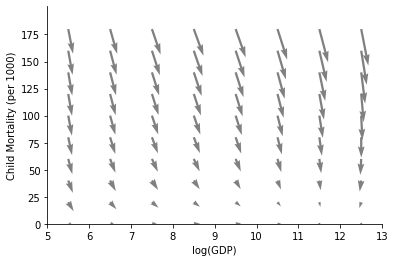

In [ ]:
# Fit model
df['G2'] = df['GDP']**2
df['CG'] = df['GDP']*df['Child Mortality']
X_train = df[['Child Mortality','C2','C3','GDP','G2','CG']]
y_train = df['Diff CM']
model = skl_lm.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
# Print the coefficients
print('The coefficients are:', model.coef_)
print('The offset is: {model.intercept_:.3f}')
G,C = np.meshgrid(np.arange(5.5, 13, step=1),np.arange(0, 200, step=20))
b = model.coef_
a =model.intercept_
dC = a + b[0] * C + b[1]*C**2 + b[2]*C**3 + b[3]*G + b[4]*G**2 + b[5]*C*G


X_train = df[['Child Mortality','C2','C3','GDP','G2','CG']]
y_train = df['Diff GDP']
model = skl_lm.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
# Print the coefficients
print('The coefficients are:', model.coef_)
print('The offset is: {model.intercept_:.3f}')
bG = model.coef_
aG =model.intercept_
dG = aG + bG[0] * C + bG[1]*C**2 + bG[2]*C**3 + bG[3]*G + bG[4]*G**2 + bG[5]*C*G


fig,ax=plt.subplots(num=1)
ax.quiver(G,C,dG*20,dC,color='grey')
ax.set_xticks(np.arange(5,13.5,step=1))
ax.set_yticks(np.arange(0,200,step=25))
ax.set_ylabel('Child Mortality (per 1000)')
ax.set_xlabel('log(GDP)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,201) 
ax.set_xlim(5,13) 
plt.show()

### 3.3 Predicting future changes.

The following code simulates child mortality and GDP on the basis of the model. It is however incorrect for GDP. Correct the model so it is consistent with the fitting in the previous section and run it to show how we would expect the two variables to change in the future.

(5.0, 11.5)

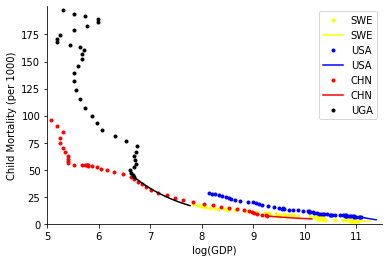

In [ ]:
#Simulate on phase portrait.
fig,ax=plt.subplots(num=1)
for country in countries:
    df_country=df.loc[df['Country'] == country]
    ax.plot(df_country['GDP'], df_country['Child Mortality'],linestyle='none', markersize=3, color =country_colour_dict[country],  marker='o',label=country)
       
    numyears=20
    future_CM=np.zeros(numyears)
    future_CM[0]=df_country['Child Mortality'][-1:]
    future_GDP=np.zeros(numyears)
    future_GDP[0]=df_country['GDP'][-1:]
    
    ax.legend()
    
    for t in range(numyears-1):
        future_CM[t+1]=future_CM[t]+ a + b[0] * future_CM[t] + b[1]*future_CM[t]**2 + b[2]*future_CM[t]**3  + b[3]*future_GDP[t] + b[4]*future_GDP[t]**2 + b[5]*future_CM[t]*future_GDP[t]
        future_GDP[t+1]=future_GDP[t]+ aG + bG[0] * future_CM[t] + bG[1]*future_CM[t]**2 + bG[2]*future_CM[t]**3 + bG[3]*future_GDP[t] + bG[4]*future_GDP[t]**2 + bG[5]*future_CM[t]*future_GDP[t]
    
    ax.plot(future_GDP,future_CM, color =country_colour_dict[country],linestyle='-',label=country)

ax.set_xticks(np.arange(5,12,step=1))
ax.set_yticks(np.arange(0,200,step=25))
ax.set_ylabel('Child Mortality (per 1000)')
ax.set_xlabel('log(GDP)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,201) 
ax.set_xlim(5,11.5)   
